In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from itertools import cycle, islice

In [2]:
# set chart style
sns.set_style("dark")
sns.set_context("notebook", font_scale=1.5, 
                rc={"lines.linewidth": 1.5})
colors = ['#91268F','#F05A28','#8CC63E','#00A7A0','#4C4C4C',
          '#BFE9E7','#7a2700']
sns.set(font="Pragmatica")

In [3]:
df = pd.read_csv(r'..\..\..\outputs\network\network_results.csv')

# Congested network components by time of day
df.columns

# Get freeflow from 20to5 period

# Exclude trips taken on non-designated facilities (facility_type == 0)
# These are artificial (weave lanes to connect HOV) or for non-auto uses 
df = df[df['data3'] != 0]    # data3 represents facility_type

# calculate total link VMT and VHT
df['VMT'] = df['@tveh']*df['length']
df['VHT'] = df['@tveh']*df['auto_time']/60

# Define facility type
df.loc[df['data3'].isin([1,2]), 'facility_type'] = 'highway'
df.loc[df['data3'].isin([3,4,6]), 'facility_type'] = 'arterial'
df.loc[df['data3'].isin([5]), 'facility_type'] = 'connector'

# Calculate delay
# Select links from overnight time of day
delay_df = df.loc[df['tod'] == '20to5'][['ij','auto_time']]
delay_df.rename(columns={'auto_time':'freeflow_time'}, inplace=True)

# Merge delay field back onto network link df
df = pd.merge(df, delay_df, on='ij', how='left')

# Calcualte hourly delay
df['total_delay'] = ((df['auto_time']-df['freeflow_time'])*df['@tveh'])/60    # sum of (volume)*(travtime diff from freeflow)

# Calcualte speed as a percent of freeflow
df['flow_index'] = df['auto_time']/df['freeflow_time']

df['county'] =df['@countyid'].map({33: 'King',
                                      35: 'Kitsap',
                                      53: 'Pierce',
                                      61: 'Snohomish'})

# FGTS

# Non-motorized extent in geographies

# High Capacity Transit Network

In [4]:
df['speed'] = df['length']/df['auto_time']*60
df['congestion_index'] = df['speed']/df['data2']
df['congestion_index'] = df['congestion_index'].clip(0,1)
df['congestion_category'] = pd.cut(df['congestion_index'], bins=[0,.25,.5,.7,1], labels=['Severe','Heavy','Moderate','Light'])

# Congestion by County Tables
### Total VMT & Percent of County VMT by Congestion Level

- **Severe: < 25% Speed Limit** (e.g., less than 15 mph on a road with speed limit of 60 mph)
- **Heavy: 25-50% Speed Limit** (e.g., 15-30 mph on a road with speed limit of 60 mph)
- **Moderate: 50-70% Speed Limit** (e.g, 30-42 mph on a road with speed limit of 60 mph)

#### All Day

In [5]:
# Percent of VMT by congestion category
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"35,264,914","4,182,980","16,222,149","14,705,257"
Moderate,"4,951,252","86,880","1,754,362","1,116,370"
Heavy,"2,521,918","45,157","656,957","514,709"
Severe,"258,552","4,369","35,055","72,511"


In [6]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,82.0%,96.8%,86.9%,89.6%
Moderate,11.5%,2.0%,9.4%,6.8%
Heavy,5.9%,1.0%,3.5%,3.1%
Severe,0.6%,0.1%,0.2%,0.4%


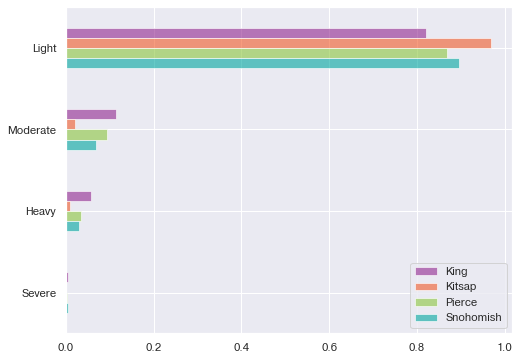

In [7]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

**Freeway** VMT by Congestion Category

In [8]:
# Segment by facility type
_df = df[df['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"17,759,220","1,762,275","6,845,377","6,957,384"
Moderate,"3,154,521","15,834","932,571","550,596"
Heavy,"1,620,154","11,049","310,259","160,106"
Severe,"86,538",334,"1,816","12,806"


**Arterial** VMT by Congestion Category

In [9]:
# Segment by facility type
_df = df[df['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"15,143,402","2,005,298","8,050,141","6,355,271"
Moderate,"1,796,731","71,046","821,791","565,773"
Heavy,"901,764","34,108","346,698","354,603"
Severe,"172,014","4,035","33,239","59,706"


#### AM Peak (7 to 8 AM)

In [10]:
pd.options.display.float_format = '{:0,.0f}'.format
df_am = df[df['tod'] == '7to8']
_df = df_am.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,173,254","304,961","995,134","946,752"
Moderate,"557,938","5,452","247,812","171,708"
Heavy,"479,664","8,255","146,926","71,784"
Severe,"37,357",289,"4,765","10,700"


In [11]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,66.9%,95.6%,71.4%,78.8%
Moderate,17.2%,1.7%,17.8%,14.3%
Heavy,14.8%,2.6%,10.5%,6.0%
Severe,1.2%,0.1%,0.3%,0.9%


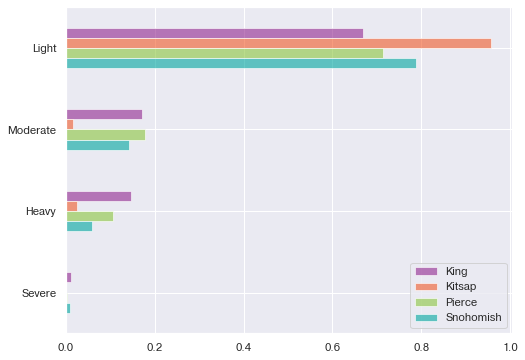

In [12]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

AM Peak **Freeway** VMT

In [13]:
# Segment by facility type
_df = df_am[df_am['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"967,947","141,607","355,616","444,081"
Moderate,"378,777",838,"165,371","119,373"
Heavy,"379,940","5,792","112,116","40,421"
Severe,"19,687",0,284,986


AM Peak **Arterial** VMT

In [14]:
# Segment by facility type
_df = df_am[df_am['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"1,065,235","140,122","560,205","421,549"
Moderate,"179,161","4,614","82,440","52,335"
Heavy,"99,723","2,463","34,809","31,363"
Severe,"17,670",289,"4,481","9,715"


#### PM Peak (5 to 6 PM)

In [15]:
pd.options.display.float_format = '{:0,.0f}'.format
df_pm = df[df['tod'] == '17to18']
_df = df_am.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,173,254","304,961","995,134","946,752"
Moderate,"557,938","5,452","247,812","171,708"
Heavy,"479,664","8,255","146,926","71,784"
Severe,"37,357",289,"4,765","10,700"


In [16]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,66.9%,95.6%,71.4%,78.8%
Moderate,17.2%,1.7%,17.8%,14.3%
Heavy,14.8%,2.6%,10.5%,6.0%
Severe,1.2%,0.1%,0.3%,0.9%


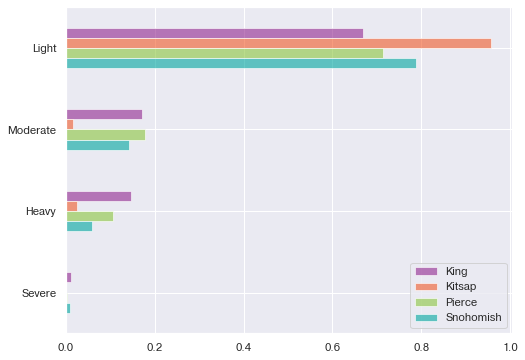

In [17]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

PM **Freeway** VMT

In [18]:
# Segment by facility type
_df = df_pm[df_pm['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"1,042,623","142,538","390,290","483,539"
Moderate,"433,402","4,904","184,585","102,237"
Heavy,"299,130","4,898","63,854","31,211"
Severe,"19,181",170,756,"1,314"


PM **Arterial** VMT

In [19]:
# Segment by facility type
_df = df_pm[df_pm['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"1,231,473","164,227","644,668","498,061"
Moderate,"225,235","6,003","96,261","66,167"
Heavy,"113,226","3,612","46,339","44,116"
Severe,"22,869",495,"4,288","9,581"


# Freight Congestion
## All Trucks (Heavy & Medium)
#### All Day

In [20]:
df['heavy_truck_vmt'] = df['length']*df['@heavy_truck']
df['medium_truck_vmt'] = df['length']*df['@medium_truck']
df['total_truck_vmt'] = df['heavy_truck_vmt']+df['medium_truck_vmt'] 

In [21]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='total_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"5,046,960","428,980","1,821,042","1,906,485"
Moderate,"787,425","5,402","215,626","130,777"
Heavy,"368,932","2,929","66,022","39,967"
Severe,"24,981",256,"2,890","3,786"


In [22]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,81.0%,98.0%,86.5%,91.6%
Moderate,12.6%,1.2%,10.2%,6.3%
Heavy,5.9%,0.7%,3.1%,1.9%
Severe,0.4%,0.1%,0.1%,0.2%


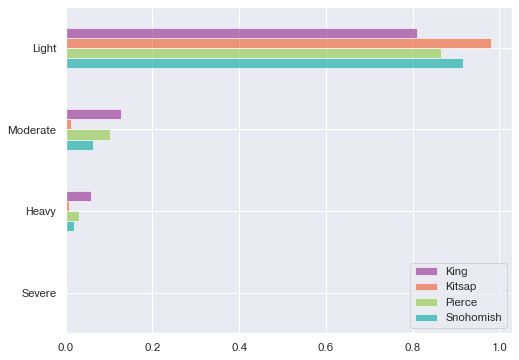

In [23]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

## Heavy Trucks

In [24]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='heavy_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,517,833","192,712","1,038,882","1,090,167"
Moderate,"383,073","1,634","130,497","63,076"
Heavy,"171,333",890,"39,725","15,239"
Severe,"9,195",97,"1,411","1,213"


In [25]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,81.7%,98.7%,85.8%,93.2%
Moderate,12.4%,0.8%,10.8%,5.4%
Heavy,5.6%,0.5%,3.3%,1.3%
Severe,0.3%,0.0%,0.1%,0.1%


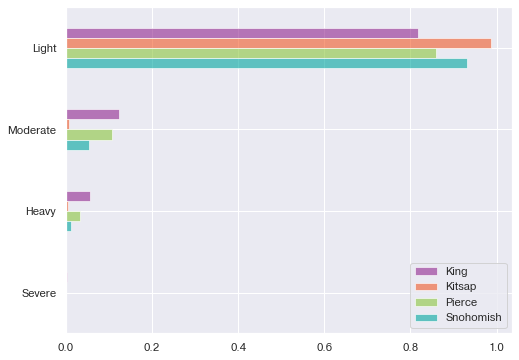

In [26]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

## Medium Trucks

In [27]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='medium_truck_vmt')

_df

county,King,Kitsap,Pierce,Snohomish
congestion_category,,,,
Severe,"15,786",159,"1,479","2,572"
Heavy,"197,598","2,039","26,297","24,728"
Moderate,"404,352","3,768","85,129","67,701"
Light,"2,529,127","236,268","782,160","816,318"


In [28]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='medium_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,529,127","236,268","782,160","816,318"
Moderate,"404,352","3,768","85,129","67,701"
Heavy,"197,598","2,039","26,297","24,728"
Severe,"15,786",159,"1,479","2,572"


In [29]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,80.4%,97.5%,87.4%,89.6%
Moderate,12.8%,1.6%,9.5%,7.4%
Heavy,6.3%,0.8%,2.9%,2.7%
Severe,0.5%,0.1%,0.2%,0.3%


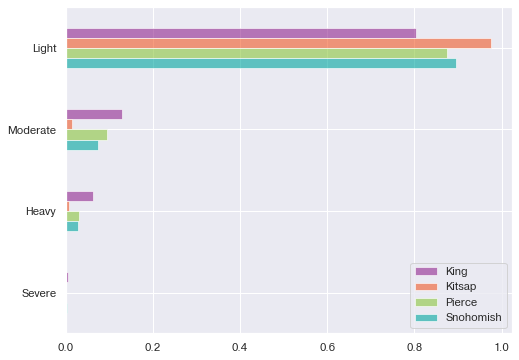

In [30]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');